- Goal: Wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.
- doggo:
    - A big pupper, usually older. this label does not stop a doggo from behaving like a pupper
    - A pupper that appears to have its life in order. Probably understands taxes and whatnot
- pupper:
    - A small dogoo, usually younger. Can be equally, if not more mature than some doggos.
    - A doggo that is inexperienced, unfamiliar, or in any way unprepared for the responsibilities associated with being a doggo
- puppo:
    - A transitional phase between pupper and doggo. Easily understood as the dog equivalent of a teenager.
    - A dog with a mixed bag of both pupper and doggo tendencies
- blep (verb):
    - An extremely subtle act that occurs without the knowledge of the one who slips. The act includes one's tongue protruding ever so slightly from the mouth, usually just noticeable enough that it attracats the attention it deserves. Can last between three seconds and four days.
- snoot:
    - The nose of a dog. Usually found in places the dog may not fit. The location of the snoot may hint at where the dog's interest lies.
- floof:
    - Any dog really. However, this label is commonly given to dogs with seemingly excess fur. Comical amounts of fur on a dog will certainly earn the dog this generic name
    - Dog fur. The term holds true whether the fur is still on the dog, or if it has been shed off.
    
##### Key points:
- We only want original ratings (no retweets) that have images.
- Fully assessing and cleaning the entire dataset requires exceptional effort so only a subset of its issues (eight (8) quality issues and two (2) tidiness issues at minimum) need to be assessed and cleaned.
- Cleaning includes merging individual pieces of data according to the rules of tidy data.
- The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.

##### Assessing Data for this Project:
- After gathering each of the above pieces of data, assess them visually and programmatically for quality and tidiness issues. Detect and document at least eight (8) quality issues and two (2) tidiness issues in your wrangle_act.ipynb Jupyter Notebook. To meet specifications, the issues that satisfy the Project Motivation (see the Key Points header on the previous page) must be assessed.

##### Cleaning Data for this Project:
- Clean each of the issues you documented while assessing. Perform this cleaning in wrangle_act.ipynb as well. The result should be a high quality and tidy master pandas DataFrame (or DataFrames, if appropriate). Again, the issues that satisfy the Project Motivation must be cleaned.

##### Storing, Analyzing, and Visualizing Data for this Project
- Store the clean DataFrame(s) in a CSV file with the main one named twitter_archive_master.csv. If additional files exist because multiple tables are required for tidiness, name these files appropriately. Additionally, you may store the cleaned data in a SQLite database (which is to be submitted as well if you do).
- Analyze and visualize your wrangled data in your wrangle_act.ipynb Jupyter Notebook. At least three (3) insights and one (1) visualization must be produced.

##### Reporting for this Project
- Create a 300-600 word written report called wrangle_report.pdf that briefly describes your wrangling efforts. This is to be framed as an internal document.
- Create a >250 word written report called act_report.pdf that communicates the insights and displays the visualization(s) produced from your wrangled data. This is to be framed as an external document, like a blog post or magazine article, for example.
- Both of these documents can be created in separate Jupyter Notebooks using the Markdown functionality of Jupyter Notebooks, then downloading those notebooks as PDF files (see image below). You might prefer to use a word processor like Google Docs or Microsoft Word, however.

In [26]:
import os
import requests
import urllib.request
import pandas as pd
import tweepy
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# WeRateDogs Tweeter Archive

### Gathering

In [ ]:
# Import CSV file
wrd_df = pd.read_csv('twitter-archive-enhanced.csv')

### Assessing

In [ ]:
wrd_df.info()

#### Summary Info
- 2356 observations
- 17 variables
- In reply data is a response to what someone else has written
- Retweet is to repost someone elses tweet
- expanded urls are the source of tweets

#### Data Quality Issues
- Missing (745) name values
    - Cannot be addressed if name was not included in tweet
- Missing (59) expanded_urls
    - Not to be addressed as most are for reply tweets (@screename) and will be removed from dataset for simplicity
- 'rating_numerator' values have significant outliers (less than 10 instances)
    - 'rating_numerator' values will need to be converted to floats to accomodate certain values from tweets
- 'rating_denominator' values are not all 10
- 'name' values contain some filler words (ex: the, a, an); all seem to be lowercase
- 'expanded_url' should be changed to a more descriptive name

#### Tidiness Issues
- Doggo, floofer, pupper, puppo columns are values themselves and should be one column
- Info regarding retweets (RT @screename) and reply tweets (@screename) may be better suited to a table on its own or not at all (retweets were requested to be disregarded)
- Reply tweets (RT @screename) lack valuable information regarding dog ratings so will be removed
- 'source' values lack valuable information so will be removed

In [ ]:
# Looking at source column
print(wrd_df.source.value_counts())

In [ ]:
# Looking at rating_numerator column
print(wrd_df.rating_numerator.value_counts())

In [ ]:
# Expand column texts to view entire strings
pd.set_option('display.max_colwidth', -1)

In [ ]:
common_numerators = [12,11,10,13,9,8,7,14,5,6,3,4]

# Dataframe that contains numerators not in common_numerators list
wrd_df[~wrd_df.rating_numerator.isin(common_numerators)]

In [ ]:
# Looking at rating_denominator column
print(wrd_df.rating_denominator.value_counts())

In [ ]:
# Evaluate why denominators are not 10
wrd_df[wrd_df.rating_denominator != 10]

- Tweet ID's with invalid denominator by visual inspection (excluding retweets, replies, and missing expanded urls):
    - 810984652412424192 (no score available)
    - 740373189193256964 (14/10)
    - 722974582966214656 (13/10)
    - 716439118184652801 (11/10)
    - 686035780142297088 (no score available)
    - 682962037429899265 (10/10)
    - 666287406224695296 (9/10)

In [ ]:
# Will be used later to fix invalid ratings
invalid_rating_ids = [810984652412424192, 740373189193256964, 722974582966214656, 716439118184652801, 686035780142297088,
                      682962037429899265, 666287406224695296, 786709082849828864, 778027034220126208, 680494726643068929]

In [ ]:
# Looking at name column
print(wrd_df.name.value_counts())

In [ ]:
# No duplicate tweet id's
print(wrd_df.tweet_id.value_counts())

In [ ]:
# Looking at dog stages
print(wrd_df.doggo.value_counts())
print(wrd_df.floofer.value_counts())
print(wrd_df.pupper.value_counts())
print(wrd_df.puppo.value_counts())

In [ ]:
# Seeing if certain combinations of dog stages exist for given booleans
print('Doggo/Floofer:', len(wrd_df[(wrd_df['doggo'] == 'doggo') & (wrd_df['floofer'] == 'floofer')]))
print('Doggo/Pupper:', len(wrd_df[(wrd_df['doggo'] == 'doggo') & (wrd_df['pupper'] == 'pupper')]))
print('Doggo/Puppo:', len(wrd_df[(wrd_df['doggo'] == 'doggo') & (wrd_df['puppo'] == 'puppo')]))
print('Floofer/Pupper:', len(wrd_df[(wrd_df['floofer'] == 'floofer') & (wrd_df['pupper'] == 'pupper')]))
print('Floofer/Puppo:',len(wrd_df[(wrd_df['floofer'] == 'floofer') & (wrd_df['puppo'] == 'puppo')]))
print('Pupper/Puppo:', len(wrd_df[(wrd_df['pupper'] == 'pupper') & (wrd_df['puppo'] == 'puppo')]))

#### Data Quality Issues
- Missing (745) name values
    - Cannot be addressed if name was not included in tweet
- Missing (59) expanded_urls
    - Not to be addressed as most are for reply tweets (@screename) and will be removed from dataset for simplicity
- 'rating_numerator' values have significant outliers (less than 10 instances)
    - 'rating_numerator' values will need to be converted to floats to accomodate certain values from tweets
- 'rating_denominator' values are not all 10
- 'name' values contain some filler words (ex: the, a, an); all seem to be lowercase
- 'expanded_url' should be changed to a more descriptive name

#### Tidiness Issues
- Doggo, floofer, pupper, puppo columns are values themselves and should be one column
- Info regarding retweets (RT @screename) and reply tweets (@screename) may be better suited to a table on its own or not at all (retweets were requested to be disregarded)
- Reply tweets (RT @screename) lack expanded_urls so will be removed for simplicity
- 'source' values lack valuable information so will be removed

### Cleaning

In [ ]:
wrd_clean = wrd_df.copy()

In [ ]:
wrd_clean.head(2)

#### Issue: 
- Reply tweets and retweets removal for simplicity

#### Solution: 
- Removal of observations regarding reply tweets and retweets

In [ ]:
# Removing observations
print('Number of observations:', len(wrd_clean))

# Remove observations that contain replied tweets
wrd_clean = wrd_clean[wrd_clean['in_reply_to_status_id'].isnull()]
print('Number of observations:', len(wrd_clean))

# Remove observations that contain retweets
wrd_clean = wrd_clean[wrd_clean['retweeted_status_id'].isnull()]
print('Number of observations:', len(wrd_clean))

#### Issue: 
- 'expanded_urls' have missing values

#### Solution: 
- Removal of observations that have missing values for 'expanded_urls'

In [ ]:
# Remove observations that do not contain a 'expanded urls'
wrd_clean = wrd_clean.dropna(subset=['expanded_urls'])
print('Number of observations:', len(wrd_clean))

#### Issue: 
- A number of columns are no longer of use due to removal of retweets and reply tweets

#### Solution: 
- Removal of unwanted_columns

In [ ]:
# Removing Columns
unwanted_columns = ['in_reply_to_status_id', 'in_reply_to_user_id', 'source', 
                    'retweeted_status_id',  'retweeted_status_user_id', 'retweeted_status_timestamp']

wrd_clean = wrd_clean.drop(labels=unwanted_columns, axis=1)

In [ ]:
# Inspection
wrd_clean.head(2)

#### Issue: 
- Dog stage columns (doggo, floofer, pupper, puppo) are values themselves and should be one category

#### Solution: 
- Melt dataframe to one column for (doggo, floofer, pupper, puppo) columns. Create 3 dataframes ('None' values, single_stage values, multi_stage values) and append together to make full dataframe. Account for tweets with multiple dog_stages

In [ ]:
# Number of multiple stage values for dog_stage columns
print(len(wrd_clean[(wrd_clean['doggo'] == 'doggo') & (wrd_clean['floofer'] == 'floofer')]))
print(len(wrd_clean[(wrd_clean['doggo'] == 'doggo') & (wrd_clean['pupper'] == 'pupper')]))
print(len(wrd_clean[(wrd_clean['doggo'] == 'doggo') & (wrd_clean['puppo'] == 'puppo')]))

In [ ]:
# tweet_id's with multiple stage columns; 
# will be used post melt, to narrow down those id's and convert category to multiple
multi_stage = wrd_clean[((wrd_clean['doggo'] == 'doggo') & (wrd_clean['floofer'] == 'floofer')) |
                     ((wrd_clean['doggo'] == 'doggo') & (wrd_clean['pupper'] == 'pupper')) |
                     ((wrd_clean['doggo'] == 'doggo') & (wrd_clean['puppo'] == 'puppo'))]

# Create series of id's that will be categorized as multiple for 'dog_stage' column post melt
multi_stage_ids = multi_stage['tweet_id']

multi_stage_ids

In [ ]:
# Melting Columns
unchanged_columns = ['tweet_id', 'timestamp', 'text', 'expanded_urls',
                    'rating_numerator', 'rating_denominator', 'name']

# Melt dataframe to long format
wrd_melt = pd.melt(wrd_clean, id_vars=unchanged_columns, value_name='dog_stage')

# Remove 'variable' column
wrd_melt = wrd_melt.drop(labels='variable', axis=1)

"""Dataframe contains multiple (4X) of each tweet_id. Will need to remove duplicate ID's"""
wrd_melt[wrd_melt['tweet_id'] == 733109485275860992] # ID of a multi_stage dog

In [ ]:
# Drops all duplicate id's that have duplicate dog_stage value
wrd_melt = wrd_melt.drop_duplicates(subset=['tweet_id', 'dog_stage']) 

"""Dataframe contains multiple entries for tweet_id's that have a dog_stage value in addition to value 'None' """
wrd_melt[wrd_melt['tweet_id'] == 733109485275860992]

In [ ]:
# Series of booleans of all duplicates
duplicate_position = wrd_melt.duplicated(subset='tweet_id', keep = False) # keep = False -> Mark all duplicates as True 

# Create Dataframe of all id's with a dog_stage value other than 'None'
duplicate_df = wrd_melt[duplicate_position] # df with duplicates
duplicate_df = duplicate_df[duplicate_df['dog_stage'] != 'None'] # keep duplicates that do not have 'None'

"""Dataframe contains entries that have a value other than 'None' for dog_stage"""
duplicate_df[duplicate_df['tweet_id'] == 733109485275860992]

In [ ]:
# Create dataframe containing only tweets with dog_stage == 'None'
none_df = wrd_melt[~duplicate_position] # ~ -> Inverse series of booleans
none_df.info()

"""Dataframe will be used later to append edited down dataframes from duplicate_df"""

In [ ]:
# Create Series of multi_stage dogs
multi_stage_dogs = duplicate_df.duplicated(subset='tweet_id', keep = 'first') # Marks all duplicates except the first as True

# Create Series of single_stage dogs
single_stage_dogs = ~duplicate_df.duplicated(subset='tweet_id', keep = False)

# Create Dataframe for multi_stage dogs
multi_stage_df = duplicate_df[multi_stage_dogs]

"""multi_stage_df is a dataframe containing only multi-stage entries"""
multi_stage_df[multi_stage_df['tweet_id'] == 733109485275860992]

In [ ]:
# Create Dataframe for single_stage dogs
single_stage_df = duplicate_df[single_stage_dogs]
single_stage_df.info()

In [ ]:
# Convert multi_stage_df dog_stage category values to multiple
multi_stage_df['dog_stage'] = 'multiple'
print(multi_stage_ids) # for comparison purposes
multi_stage_df['tweet_id']

In [ ]:
# Append all dataframes (None, single_stage, and multi_stage) together
appending_dfs = [single_stage_df, multi_stage_df]
wrd_clean_2 = none_df.append(appending_dfs)

In [ ]:
# Before
wrd_clean.info()

In [ ]:
# After
wrd_clean_2.info()

In [ ]:
# Reset index
wrd_clean_2 = wrd_clean_2.reset_index(drop=True)

#### Issue: 
- 'name' variable contains values that aren't names (a, an, the, etc.)

#### Solution: 
- Change lowercase values for 'name' variable to 'None'

In [ ]:
pattern = r'^[a-z]' # first letter is lowercase

# Create Series where regex pattern is satisfied
lowercase_values = wrd_clean_2.name.str.contains(pattern)
lowercase_values.value_counts() 

In [ ]:
# Create Dataframe that contains observations with lowercase names
lowercase_df = wrd_clean_2[lowercase_values]

In [ ]:
lowercase_names = []

# add lowercase_df.name elements to a list; forms list of words to be replaced
for element in lowercase_df.name:
    if element not in lowercase_names:
        lowercase_names.append(element)
        
print('Name values to be replaced:', lowercase_names)

In [ ]:
wrd_clean_3 = wrd_clean_2.copy()

In [ ]:
# Conversion of lowercase names to 'None'
wrd_clean_3.name.replace(to_replace=lowercase_names, value='None', inplace=True)

In [ ]:
# Before
wrd_clean_2.name.value_counts()

In [ ]:
# After
wrd_clean_3.name.value_counts()

#### Issue: 
- Invalid 'rating_denominator' and 'rating_numerator' values

#### Solution: 
- Change 'numerator_rating' from int to float dtype. Replace each incorrect value with appropriate value marked in notes.

#### Notes from assessment:
- 810984652412424192 (no score available, will use median value of numerator and 10 as denominator)
- 740373189193256964 (14/10)
- 722974582966214656 (13/10)
- 716439118184652801 (11/10)
- 686035780142297088 (no score available, will use median value of numerator and 10 as denominator)
- 682962037429899265 (10/10)	
- 666287406224695296 (9/10)
- 786709082849828864 (9.75/10)
- 778027034220126208 (11.27/10)
- 680494726643068929 (11.26/10)

In [ ]:
invalid_rating_ids

In [ ]:
wrd_clean_4 = wrd_clean_3.copy()

In [ ]:
# Convert rating_numerator to dtype float
wrd_clean_4['rating_numerator'] = wrd_clean_4['rating_numerator'] * 1.0

wrd_clean_4.info()

In [ ]:
# Create Series of booleans where invalid_ratings_ids are true
invalid_series = wrd_clean_4.tweet_id.isin(invalid_rating_ids)

# Create Dataframe of invalid_ratings_ids to see index values
invalid_df = wrd_clean_4[invalid_series]
invalid_df

In [ ]:
# Median value of rating_numerator
numerator_median = wrd_clean_4.rating_numerator.median()

# Replace 'rating_numerator' values
wrd_clean_4.at[331, 'rating_numerator'] = numerator_median
wrd_clean_4.at[437, 'rating_numerator'] = 9.75
wrd_clean_4.at[693, 'rating_numerator'] = 14
wrd_clean_4.at[765, 'rating_numerator'] = 13
wrd_clean_4.at[795, 'rating_numerator'] = 11
wrd_clean_4.at[1155, 'rating_numerator'] = 10
wrd_clean_4.at[1195, 'rating_numerator'] = 11.26
wrd_clean_4.at[1738, 'rating_numerator'] = 9
wrd_clean_4.at[1872, 'rating_numerator'] = 11.27

In [ ]:
# Before
wrd_clean_3.iloc[437]

In [ ]:
# After
wrd_clean_4.iloc[437]

#### Issue: 
- 'expanded_url' should have a more descriptive name

#### Solution: 
- Change column name to 'tweet_urls'

In [ ]:
wrd_clean_5 = wrd_clean_4.copy()

# Change a specific columns name
wrd_clean_5 = wrd_clean_5.rename(columns = {'expanded_urls':'tweet_urls'})

In [ ]:
# Before
wrd_clean_4.head(1)

In [ ]:
# After
wrd_clean_5.head(1)

### Creating Additional Data

In [ ]:
# Adding Columns
wrd_clean_6 = wrd_clean_5.copy()

# Create a rating_score from numerator and denominator ratings
wrd_clean_6['rating_score'] = wrd_clean_6['rating_numerator'] / wrd_clean_6['rating_denominator']

In [ ]:
wrd_clean_6.head(1)

In [ ]:
# Change column order
wrd_clean_6 = wrd_clean_6.reindex_axis(['tweet_id', 'timestamp', 'text', 'tweet_urls',
                                       'rating_numerator', 'rating_denominator', 'rating_score',
                                       'name', 'dog_stage'], axis=1)

wrd_clean_6.head(1)

# Dog Classification

### Gathering

In [24]:
tsv_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

# Download TSV file from a url; neural network dog classification
dog_class = pd.read_csv(tsv_url, sep='\t')

In [31]:
# Save file to folder
# urllib.request.urlretrieve(tsv_url, '.../AnacondaProjects/Udacity-ND-Data_Analyst/7-Data_Wrangling/image-predictions.tsv')

### Assessing

In [ ]:
dog_class.info()

#### Summary Info
- 2075 observations
- 12 variables
- img_num is the number of the image in the tweet (tweets can contain 4 images)
- p1-p3 are 3 top predictions for an image in a tweet by how confident in percent
- p1_dog indicates wether or not the image is of a dog

#### Data Quality Issues
- None currently present

#### Tidiness Issues
- None currently present

In [ ]:
dog_class.head()

In [ ]:
# Check for duplicates
duplicates = dog_class.duplicated(subset='tweet_id', keep = False) # Mark all duplicates as True
duplicates.value_counts()

# Twitter API Data

#### Gather:
- Each tweet's retweet count and favorite (i.e. "like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. Note: do not include your Twitter API keys and access tokens in your project submission.

#### How to Query Twitter Data
- In this project, you'll be using Tweepy to query Twitter's API for additional data beyond the data included in the WeRateDogs Twitter archive. This additional data will include retweet count and favorite count.

### Gathering

In [ ]:
# Collect tweet_ids from cleaned WeRateDogs dataset
tweet_ids = wrd_clean_6['tweet_id']

# How many tweet_ids
print('Number of tweets:', len(tweet_ids))

In [ ]:
# Querying the twitter API

import tweepy
import json

consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# Construct the API instance
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
"""
ONLY RUN SCRIPT ONCE, UNLESS TWITTER ID'S QUERIED HAS CHANGED
"""

status_list = []

# Iterate over tweet_ids to get information on each
for tweet_id in tweet_ids:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended') # returns a status object
        
    # Account for missing id's error
    except tweepy.TweepError:
        continue
    status_list.append(tweet) # add each status to status_list

In [ ]:
"""
ONLY RUN SCRIPT ONCE, UNLESS TWITTER ID'S QUERIED HAS CHANGED
"""

# Converts each status in status list to a string and appends each string to a txt file
with open('tweet_json.txt', 'a') as outfile:
    for status in status_list:
        json.dump(status._json, outfile) # converts status object to json obj and then append json obj as a string to file
        outfile.write('\n') # adds a new line after each iteration

print('Number of lines of text:', len(status_list))

In [ ]:
# Reading in JSON files to a list
tweets = []
with open('tweet_json.txt', 'r') as f:
    for line in f.readlines(): # readlines -> reads each line of the file and appends each line to a list and returns that list
        tweets.append(json.loads(line)) # adds each json line to tweets list

In [ ]:
twitter_api_df = pd.DataFrame(tweets)

### Assessing

In [ ]:
twitter_api_df.info()

#### Summary Info
- 2094 observations
- 30 columns
- Many columns are not useful for analysis and will be dropped.
- Only 'id', 'favorite_count', and 'retweet_count' will be collected

#### Data Quality Issues
- 'id' should be changed to be more descriptive

#### Tidiness Issues
- Many variables are not important for future data analysis and should be removed

In [ ]:
# Check for duplicates
twitter_duplicates = twitter_api_df.duplicated(subset='id', keep = False) # Mark all duplicates as True
twitter_duplicates.value_counts()

### Cleaning

In [ ]:
# Create Dataframe with columns of interest
columns_of_interest = ['id', 'favorite_count', 'retweet_count']
twitter_api_clean = twitter_api_df.filter(columns_of_interest, axis=1)
twitter_api_clean.info()

#### Issue: 
- 'id' is not very descriptive.

#### Solution: 
- Change column name to 'tweet_id' to match other datasets

In [ ]:
# Change a specific columns name
twitter_api_clean = twitter_api_clean.rename(columns = {'id':'tweet_id'})
twitter_api_clean.head(2)

# Merging Datasets

In [ ]:
# Merge WeRateDogs Archive with Dog Classification datasets
merge_df_1 = pd.merge(wrd_clean_6, twitter_api_clean, on='tweet_id', how='inner')
merge_df_1.info()

### Assessing

In [ ]:
# Merge Twitter_API dataset with merged dataset
master_df = pd.merge(merge_df_1, dog_class, on='tweet_id', how='inner')
master_df.info()

#### Summary Info
- 1971 observations
- 22 columns

#### Data Quality Issues
- No apparent data quality issues

#### Tidiness Issues
- No apparent tidiness issues

In [ ]:
# Convert dataframe to csv file
master_df.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

In [ ]:
master_df[master_df.rating_score > 1.4]

# Visualizations

In [56]:
# Import CSV file
df = pd.read_csv('twitter_archive_master.csv')

,tweet_id,timestamp,text,tweet_urls,rating_numerator,rating_denominator,rating_score,name,dog_stage,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,1.3,Phineas,None,39371,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,1.3,Tilly,None,33694,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,1.2,Archie,None,25390,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,1.3,Darla,None,42739,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,1.2,Franklin,None,40899,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [8]:
# Figure Parameters
% pylab inline
sns.set(style="darkgrid", font_scale=1.2);

Populating the interactive namespace from numpy and matplotlib


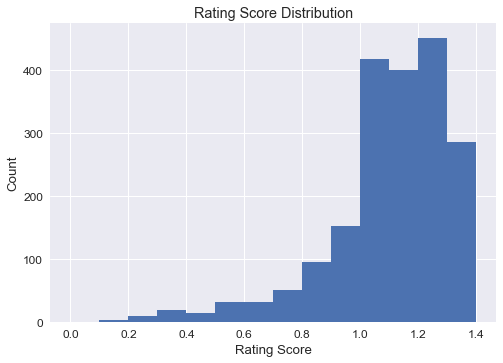

In [32]:
# Histogram of Rating_scores; reduced window to exclude 4 data points with rating_score > 1.4
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4]

plt.hist(df['rating_score'], bins);
plt.xlabel('Rating Score');
plt.ylabel('Count');
plt.title('Rating Score Distribution');

savefig('rating_score_distribution.jpg')

- WeRateDogs seems to favor giving ratings above 1.0

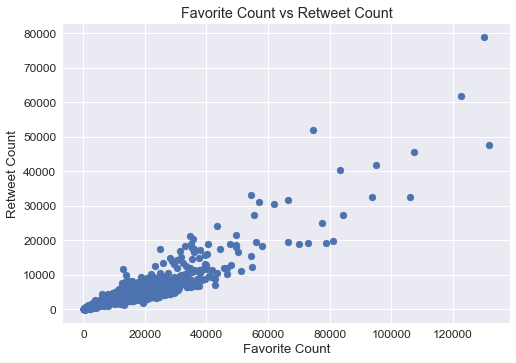

In [33]:
# Scatterplot favorite_count vs retweet_count
plt.scatter(x=df['favorite_count'], y=df['retweet_count'])
plt.xlabel('Favorite Count');
plt.ylabel('Retweet Count');
plt.title('Favorite Count vs Retweet Count');

savefig('fav_count_vs_retweet_count.jpg')

- There seems to be a strong positive correlation between the number of times a tweet was favorited and how many times it was retweeted

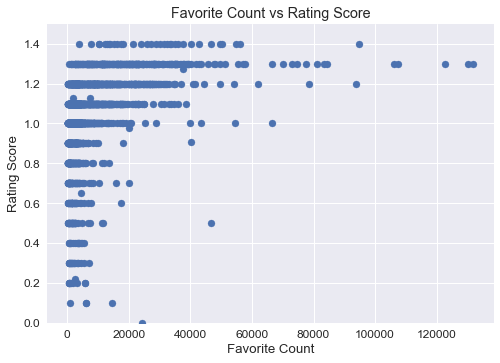

In [34]:
# Scatterplot Favorite Count vs Rating Count
plt.scatter(x=df['favorite_count'], y=df['rating_score'])
plt.ylim(0, 1.5)
plt.xlabel('Favorite Count');
plt.ylabel('Rating Score');
plt.title('Favorite Count vs Rating Score');

savefig('fav_count_vs_rating_score.jpg')

- As the rating score increases for each tweet, there seems to be increasing favorite count

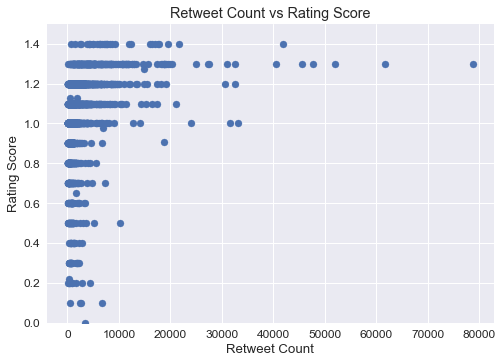

In [35]:
# Scatterplot Retweet Count vs Rating Count
plt.scatter(x=df['retweet_count'], y=df['rating_score'])
plt.ylim(0, 1.5)
plt.xlabel('Retweet Count');
plt.ylabel('Rating Score');
plt.title('Retweet Count vs Rating Score');

savefig('retweet_count_vs_rating_score.jpg')

- As the rating score increases for each tweet, there seems to be increasing retweet count

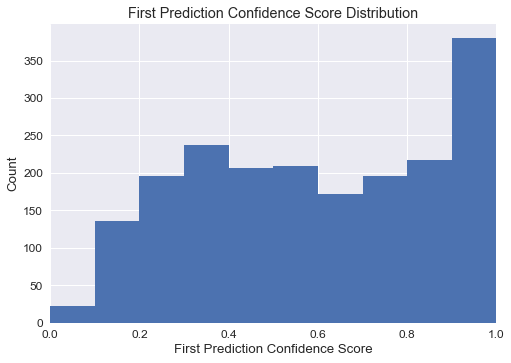

In [60]:
# Histogram of first prediction Confidence Scores
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.hist(df['p1_conf'], bins);
plt.xlim(0,1.0)
plt.xlabel('First Prediction Confidence Score');
plt.ylabel('Count');
plt.title('First Prediction Confidence Score Distribution');

savefig('first_prediction_distribution.jpg')

- The majority of first predictions of the type of animal in the tweet images is below 80%.

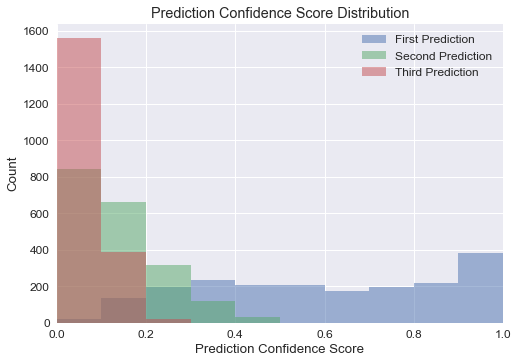

In [61]:
# Histogram of Prediction Confidence Scores
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.hist(df['p1_conf'], bins, alpha=0.5, label='First Prediction');
plt.hist(df['p2_conf'], bins, alpha=0.5, label='Second Prediction');
plt.hist(df['p3_conf'], bins, alpha=0.5, label='Third Prediction');
plt.xlim(0,1.0)
plt.xlabel('Prediction Confidence Score');
plt.ylabel('Count');
plt.title('Prediction Confidence Score Distribution');
plt.legend(loc='upper right');

savefig('prediction_score_distribution.jpg')

- The animal classifications for the tweet images seem to be for the most part not very confident after the first prediction.
- By the second prediction, predictions are vastly under 40% confident
- By the third prediction, predictions are vastly under 20% confident